In [1]:
import os
import pandas as pd
import parse
from transliterate import translit

labels = "/home/peterr/macocu/Varieties/BCMS/Denis_hrsrTweets.txt"
additional_labels =  "/home/peterr/macocu/Varieties/BCMS/Denis_hrsrTweets_additional.txt"

p = parse.compile("users/{username}{whitespace:s}{language}\n")
userdict = dict()
with open(labels, "r") as labelfile:
    for line in labelfile.readlines():
        line = translit(line, "sr", reversed=True)
        found = p.parse(line)
        userdict[found["username"]] = found["language"]
with open(additional_labels, "r") as labelfile:
    for line in labelfile.readlines():
        #line = translit(line, "sr", reversed=True)
        found = p.parse(line)
        userdict[found["username"]] = found["language"]

twitter_data_dir = "/home/peterr/macocu/Varieties/BCMS/users"
datafiles = os.listdir(twitter_data_dir)

missing = [filename for filename in datafiles if filename not in userdict.keys()]
len(missing)

386

In [2]:
from bs4 import BeautifulSoup
from typing import List
def read_user_tweets(filename: str) -> List[str]:
    with open(filename, "r") as f:
        content = "<data>"+f.read()+"<\data>"
    data = BeautifulSoup(content, "xml")
    tweets = data.findAll("tweet")
    return [tweet.find("text").text for tweet in tweets]
def to_latin(tweet: str) -> str:
    for lang in ["sr", "mk"]:
        tweet = translit(tweet, lang, reversed=True)
    return tweet

dataset = dict()
for user, language in userdict.items():
    filename = os.path.join(twitter_data_dir, user)
    tweets = read_user_tweets(filename)
    corrected_tweets = list(map(to_latin, tweets))
    corrected_tweets = [t for t in corrected_tweets if len(t) > 0]
    dataset[user] = {"language": language, "tweets": corrected_tweets}


In [6]:
import pickle
with open("/home/peterr/macocu/taskB/data/final/twitter_full_ds_only_transliterated.pickle", "wb") as f:
    pickle.dump(dataset, f)

# Generating a JSON dataset and aux plots:

In [13]:
import pickle
import matplotlib.pyplot as plt
plt.style.use("science,no-latex".split(","))
import pandas as pd
with open("/home/peterr/macocu/taskB/data/final/twitter_full_ds_only_transliterated.pickle", "rb") as f:
    ds = pickle.load(f)

data = list()
for user in ds.keys():
    lang = ds[user]["language"]
    data.append(
        {
            "user": user,
            "language": lang,
            "tweets": [i for i in ds.get(user).get("tweets")]
        }
    )
# import re
df = pd.DataFrame(data=data)
# df["tweets"] = df.tweets.apply(lambda l: [re.sub('\s+', ' ', s) for s in l]).apply(lambda l: [s for s in l if s != " "])

df.head()

,user,language,tweets
0,LeoVinkovic,hr,[RT @_marin: Hahahaha! @leovinkovic i ja iz pe...
1,Vanjuus,sr,[Like it. RT @Speranca: Jureći ljubav. Novi si...
2,Mracness,sr,"[Ali nije mi ... Hvala http://t.co/QEOV0Je64K,..."
3,MilenaMina1,sr,"[Today stats: 36 followers, 2 unfollowers and ..."
4,JeremicJeremic,sr,"[4 leka koja treba da koristim za uho,ah, @Evo..."


<ipython-input-14-ee9c7f5b1b3d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["count"] = subset.tweets.apply(lambda l: sum([len(i) for i in l]))


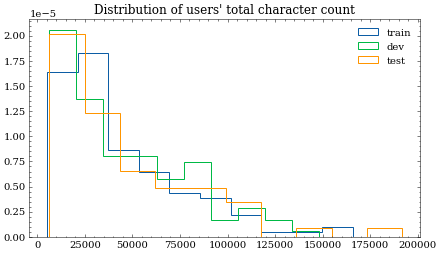

In [14]:
from sklearn.model_selection import train_test_split

train, devtest = train_test_split(df, stratify = df.language, random_state=42, train_size=0.6)
dev, test = train_test_split(devtest, stratify=devtest.language, random_state=42, train_size=0.5)

for subset in [dev, train, test, df]:
    subset["count"] = subset.tweets.apply(lambda l: sum([len(i) for i in l]))



plt.figure(figsize=(7,4))

for name, subset in zip(["train", "dev", "test"],[train, dev, test]):
    plt.hist(subset["count"],
            label=f"{name}", histtype="step", density=True)

plt.title("Distribution of users' total character count")
plt.legend()
plt.savefig("twitter_dataset/images/users_length_distribution.png")

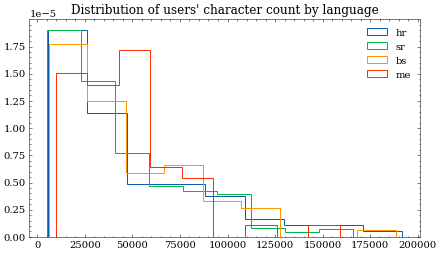

In [15]:
plt.figure(figsize=(7,4))

for lang in df.language.unique():
    subset = df.loc[df.language==lang, "count"]
    plt.hist(subset, label=f"{lang}", density=True, histtype="step", bins=9)

plt.title("Distribution of users' character count by language")
plt.legend()
plt.savefig("twitter_dataset/images/language_length_distribution.png")

In [16]:
for name, subset in zip(["train", "dev", "test"],[train, dev, test]):
    subset["split"] = name

<ipython-input-16-58645e1fb4f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["split"] = name


In [17]:
df_out = pd.concat([train, dev, test], ignore_index=True)

df_out.head()

,user,language,tweets,count,split
0,danijelzv,bs,[RT @BojanSolaja: Isto srce kao '95! #Srbija #...,90667,train
1,SavkaGazivoda,me,[@Daree14 hahhahahahahahaha mogao si danas i i...,64949,train
2,psiha_je_cudo,sr,"[@radenkovicc moguce i to, @radenkovicc ne zna...",77016,train
3,ubuntu_hr,hr,[Objavljen je #Ubuntu 13.04 (#Raring Ringtail)...,18308,train
4,mladisuzakon,sr,[Konkurs za volontera/volonterku | Fondacija A...,37862,train


In [18]:
df_out.loc[:, ["user", "language", "split", "tweets"]].to_json("twitter_dataset/twitter.json", orient="records", indent=4,)

In [19]:
df_out.language.value_counts()

sr    394
hr     89
bs     75
me     56
Name: language, dtype: int64